# Исследование графа социальной сети HAMSTERSTER,
# Юдин Никита, 517 группа

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
from tqdm import tqdm_notebook
import pickle as pkl
from collections import Counter
from subprocess import call
import os
import sys
import gc
gc.enable()
sns.set(font_scale=1.35)
import powerlaw
import warnings
#warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(12, 9)
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='normal')
plt.rc('font', size=16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=16)

In [3]:
call("wget -t inf http://konect.uni-koblenz.de/downloads/tsv/petster-friendships-hamster.tar.bz2".split())
os.system("tar xvjf petster-friendships-hamster.tar.bz2\nrm petster-friendships-hamster.tar.bz2")

0

In [4]:
df = pd.read_csv('./petster-friendships-hamster/ent.petster-friendships-hamster-uniq', index_col=0, sep=' ',
                 header=None, skiprows=3, names=['vertex', 'name', 'joined', 'species', 'coloring', 'gender',
                                                 'birthday', 'age', 'hometown', 'favorite_toy',
                                                 'favorite_activity', 'favorite_food'],
                 encoding='cp1251')
df.head()

name            joined           species coloring  gender  \
vertex                                                                      
1             Dexter    August 1, 2006   Hamster (Dwarf)   Blonde    Male   
2              Tonks    April 15, 2004  Hamster (Syrian)   Golden  Female   
3       Bunny-Rabbit  October 27, 2004  Hamster (Syrian)    Black  Female   
4               Nana      June 6, 2006  Hamster (Syrian)    Cream  Female   
5              Julia   January 5, 2006  Hamster (Syrian)    Cream  Female   

                birthday                     age  \
vertex                                             
1          June 20, 2006  Gone to Hamster Heaven   
2          June 20, 2003  Gone to Hamster Heaven   
3         August 1, 2002  Gone to Hamster Heaven   
4       October 16, 2004  Gone to Hamster Heaven   
5          April 1, 2003  Gone to Hamster Heaven   

                                    hometown                     favorite_toy  \
vertex                                                                          
1       Vernon Hills, IL&nbsp; United States  Toilet Paper, paper towels, etc   
2       Windsor Mill, MD&nbsp; United States            wooden hamster bunker   
3         Chatsworth, GA&nbsp; United States                          Carpet?   
4                              Tokyo,  Japan                         My wheel   
5                              Tokyo,  Japan                     Wooden block   

                      favorite_activity        favorite_food  
vertex                                                        
1       Toilet Paper, paper towels, etc              Lettuce  
2                 wooden hamster bunker  just about anything  
3                               Carpet?             Doritoes  
4                              My wheel    Corn and broccoli  
5                          Wooden block      Sunflower seeds

In [5]:
df.loc[30:35, :]

name             joined           species         coloring  \
vertex                                                                        
30          Dixiebell      April 4, 2008   Hamster (Dwarf)  Cinnamon Banded   
31      White Retardy  November 18, 2006   Hamster (Dwarf)            White   
32               Luiz     March 12, 2008  Hamster (Syrian)           Golden   
33              Dixie      March 4, 2008  Hamster (Syrian)            White   
34               Spot      March 4, 2008  Hamster (Syrian)           Silver   
35            Delilah      March 4, 2008  Hamster (Syrian)           Silver   

        gender           birthday        age                    hometown  \
vertex                                                                     
30      Female  December 14, 2007  50 months       Sinagpore,  Singapore   
31        Male     August 1, 2006  66 months       Singapore,  Singapore   
32        Male   November 9, 2006  63 months           Kolding,  Denmark   
33      Female   January 16, 2008  49 months  Edinburgh,  United Kingdom   
34      Female   January 16, 2008  49 months  Edinburgh,  United Kingdom   
35      Female   November 1, 2007  51 months  Edinburgh,  United Kingdom   

             favorite_toy  favorite_activity    favorite_food  
vertex                                                         
30                  pigsy              pigsy  sunflower seeds  
31        Drinking bottle    Drinking bottle         All food  
32           hamster ball       hamster ball    yoghurt drops  
33      toilet roll tubes  toilet roll tubes           grapes  
34                  wheel              wheel          raisins  
35                  wheel              wheel          peanuts

In [6]:
edges_file = open('./petster-friendships-hamster/out.petster-friendships-hamster-uniq', 'r')
lines = edges_file.readlines()

edges = []
for line in lines[1:]:
    edge = line.split()
    edges.append((int(edge[0]), int(edge[1])))

In [7]:
G = nx.Graph()
G.add_nodes_from(df.index.values)
G.add_edges_from(edges)

In [8]:
def plotting(G, title='Сеть', layout='graphviz', figsize=(16, 16), colors=None, draw_color_bar=False,
             cmap=plt.cm.plasma, node_sizes=28):
    if colors is None:
        color_list = np.zeros(G.number_of_nodes(), dtype=np.int64)
        d = nx.coloring.greedy_color(G, strategy='largest_first')
        for n, c in d.items():
            color_list[n - 1] = c
    else:
        color_list = colors
    
    fig = plt.figure(1)
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, num=1)
    fig.set_size_inches(figsize[0], figsize[1])
    plt.sca(ax)
    
    if layout == 'graphviz':
        pos = nx.nx_pydot.graphviz_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'bipartite':
        top = nx.bipartite.sets(G)[0]
        pos = nx.bipartite_layout(G, top)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    elif layout == 'random':
        pos = nx.random_layout(G)
    elif layout == 'shell':
        pos = nx.shell_layout(G)
    elif layout == 'spring':
        pos = nx.spring_layout(G)
    else:
        pos = nx.spectral_layout(G)
    
    vmin = min(0, min(color_list))
    vmax = max(1, max(color_list))
    
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, with_labels=True, node_color=color_list, vmin=vmin,
                           vmax=vmax, cmap=cmap, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos=pos, ax=ax)
    
    ax.set_title(title, fontsize=16)
    ax.set_axis_off()
    
    if draw_color_bar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        plt.colorbar(sm)
    
    plt.show()

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


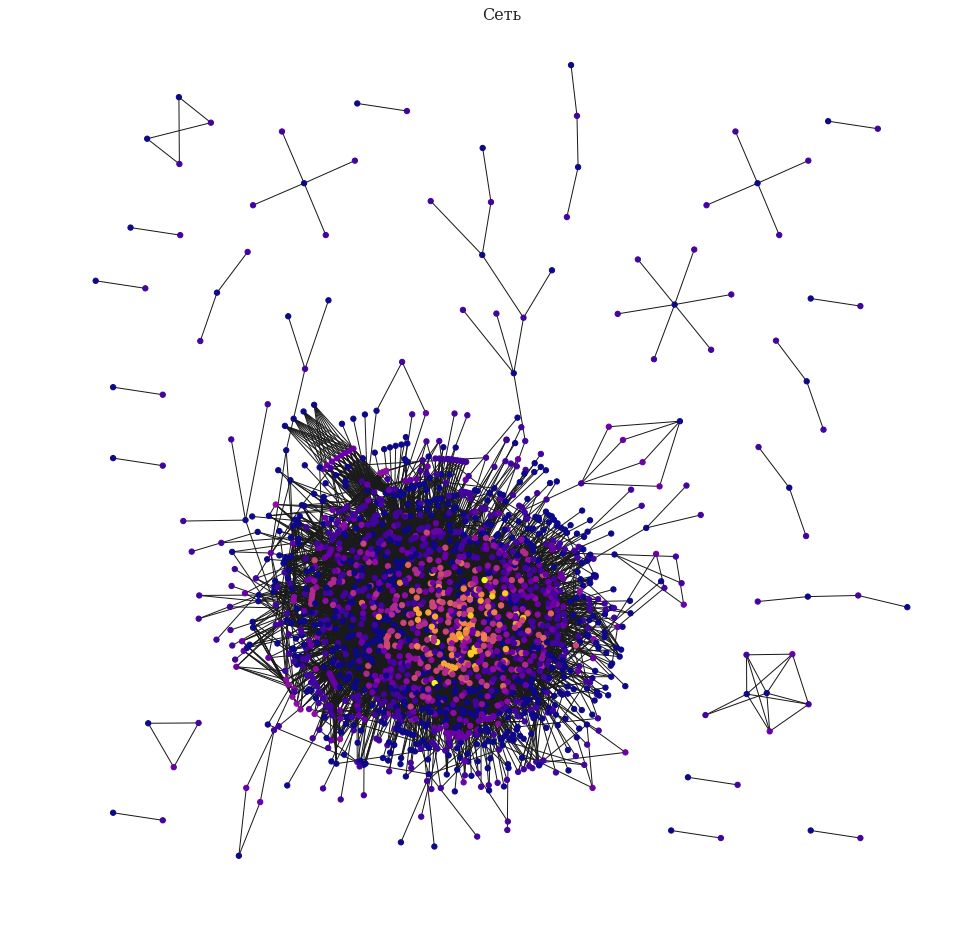

In [9]:
plotting(G)

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


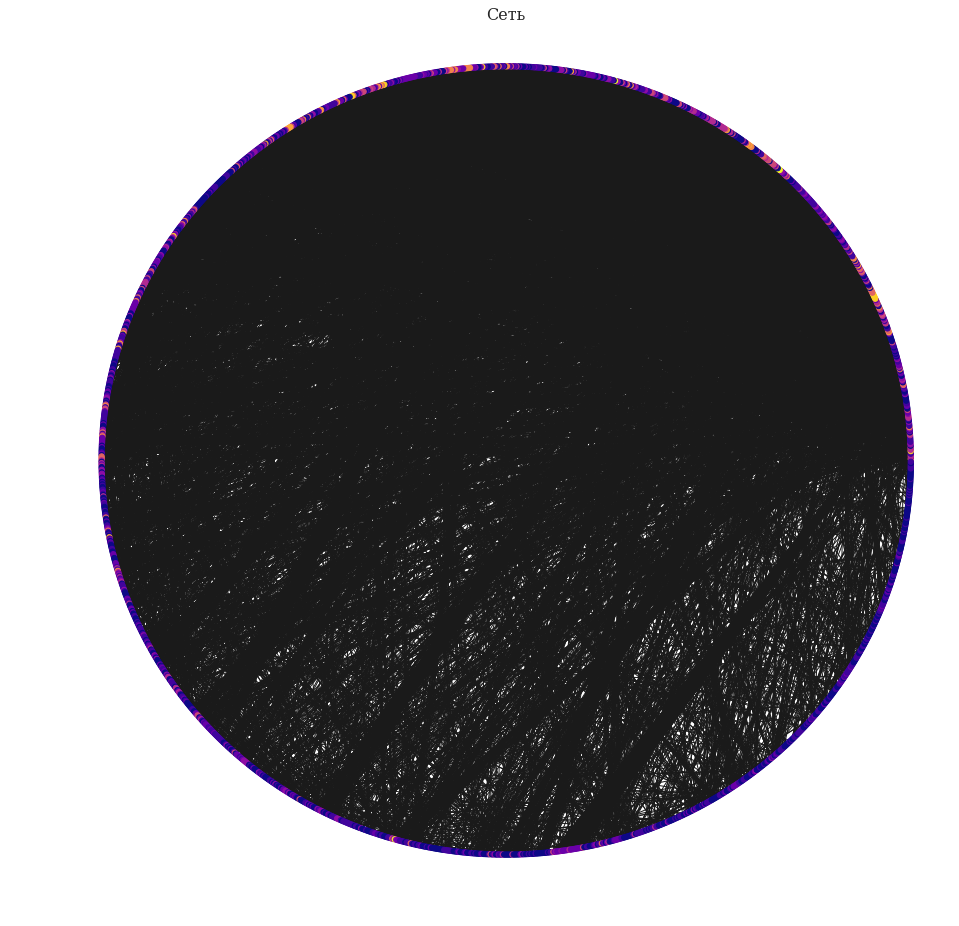

In [10]:
plotting(G, layout='circular')

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


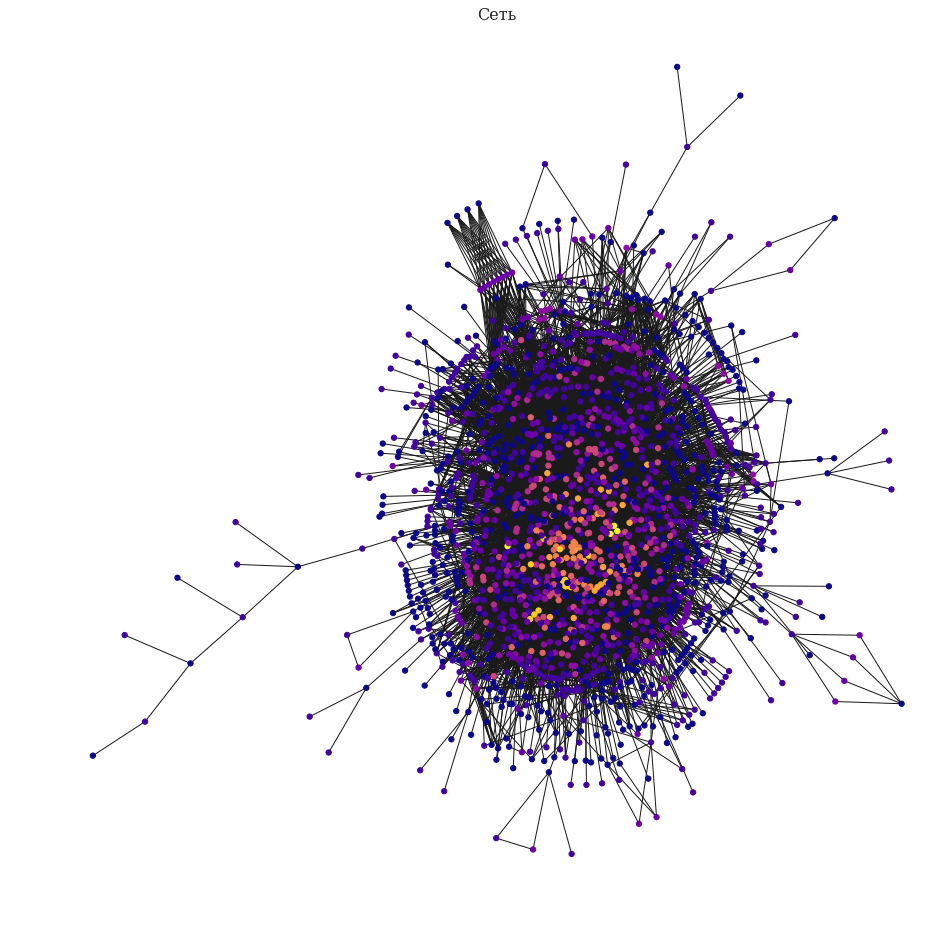

In [11]:
plotting(G, layout='kamada_kawai')

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


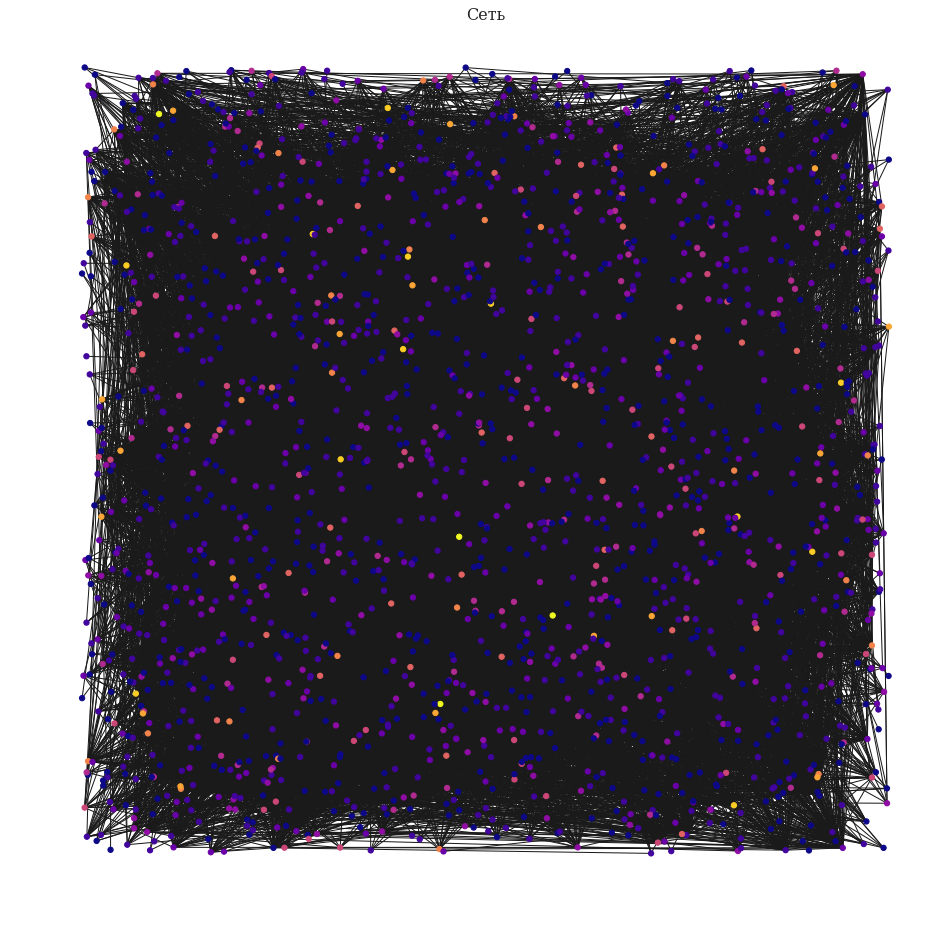

In [12]:
plotting(G, layout='random')

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


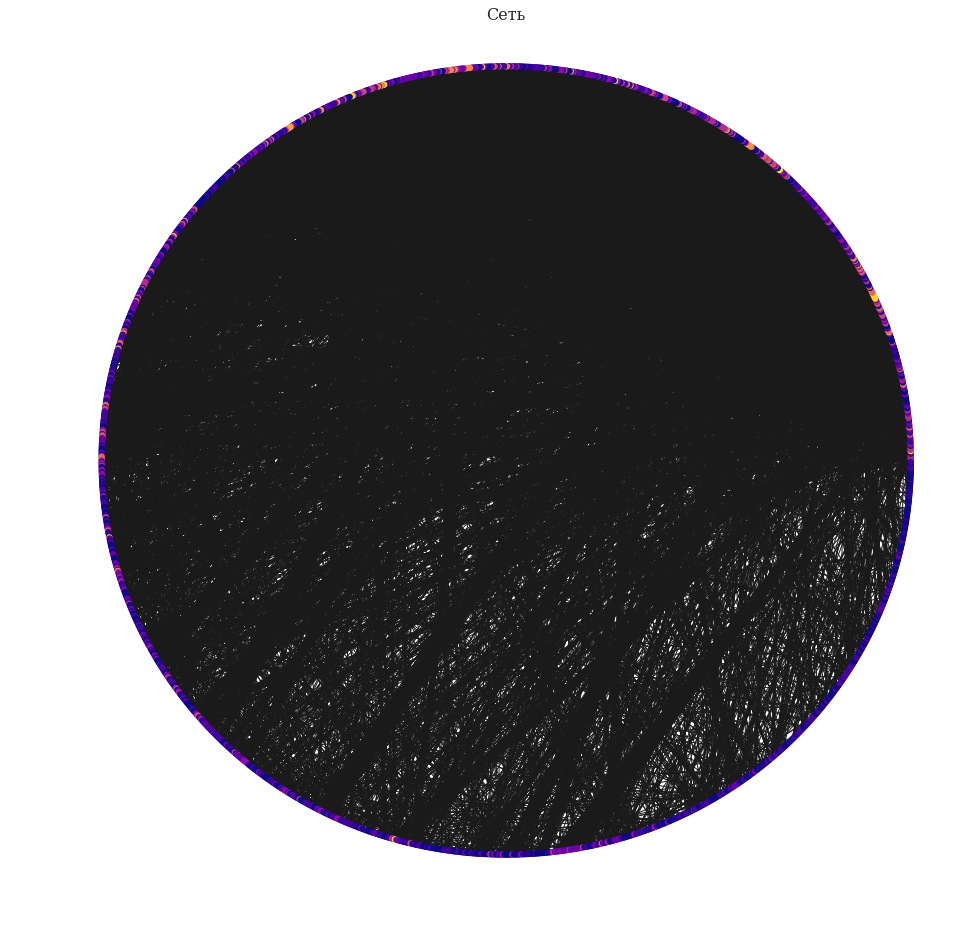

In [13]:
plotting(G, layout='shell')

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


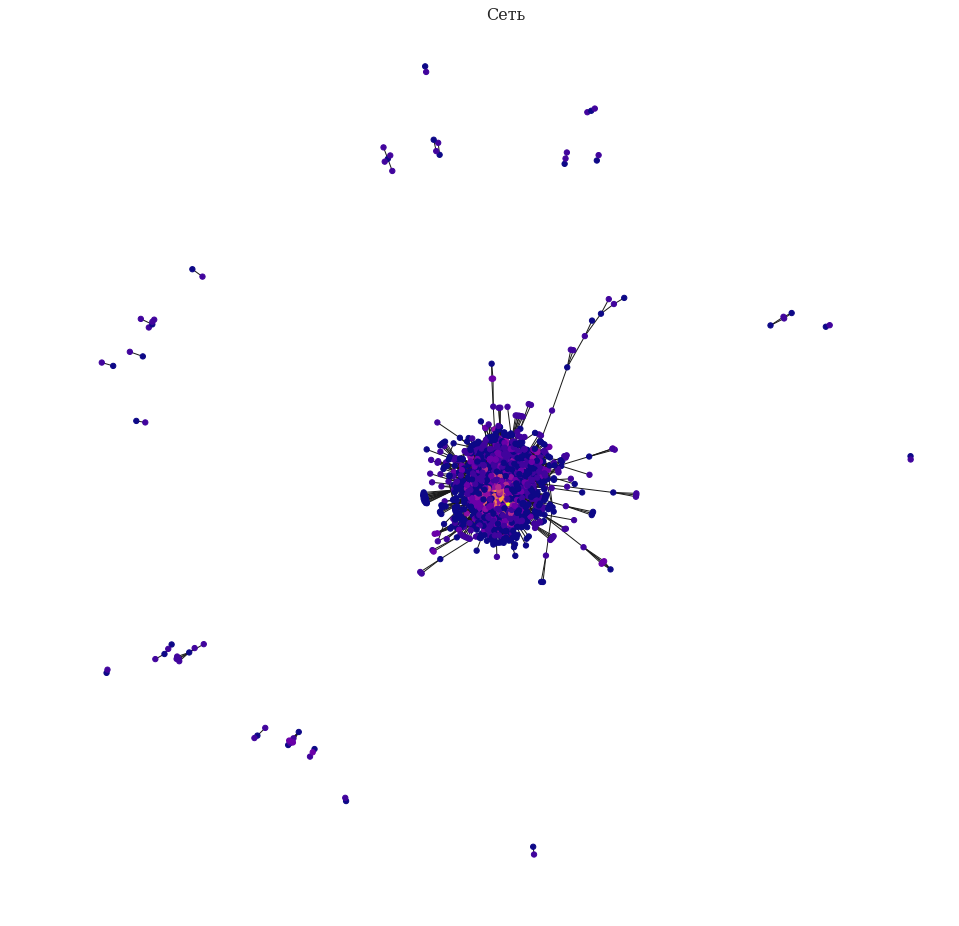

In [14]:
plotting(G, layout='spring')

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


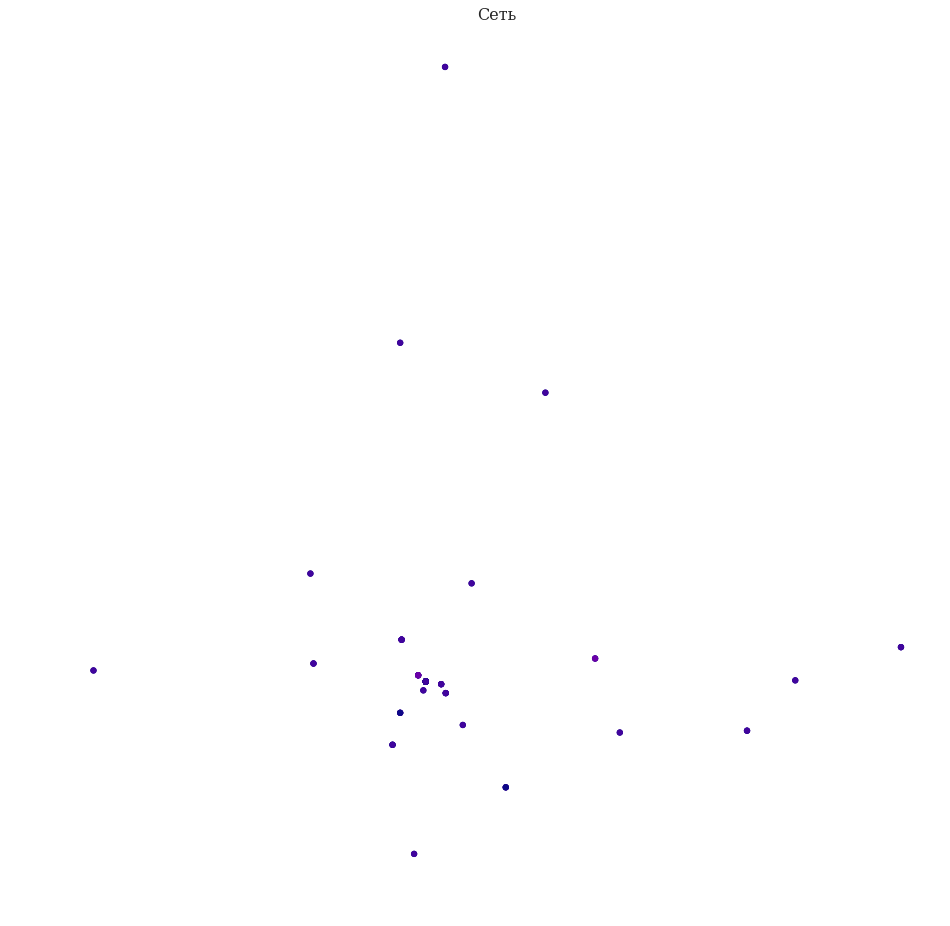

In [15]:
plotting(G, layout=None)

/usr/local/lib/python3.5/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


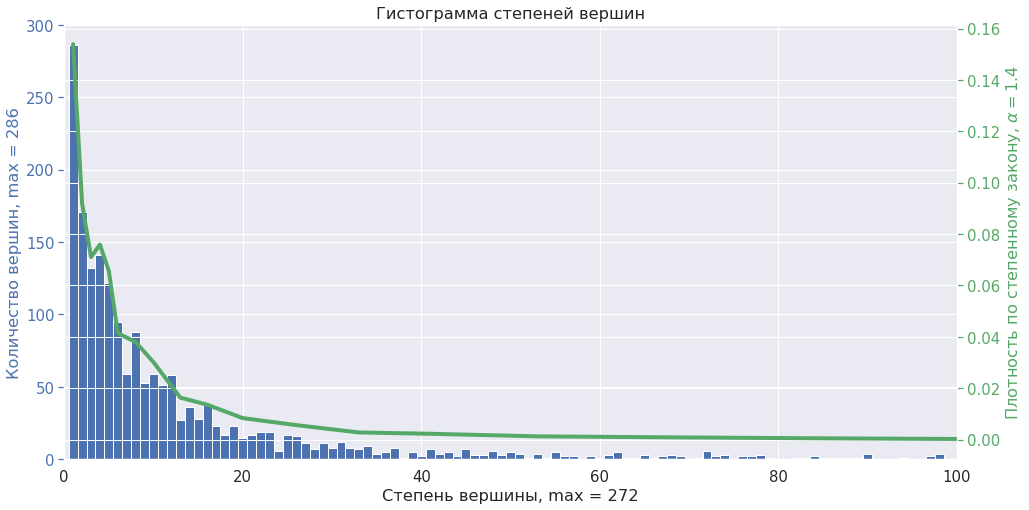

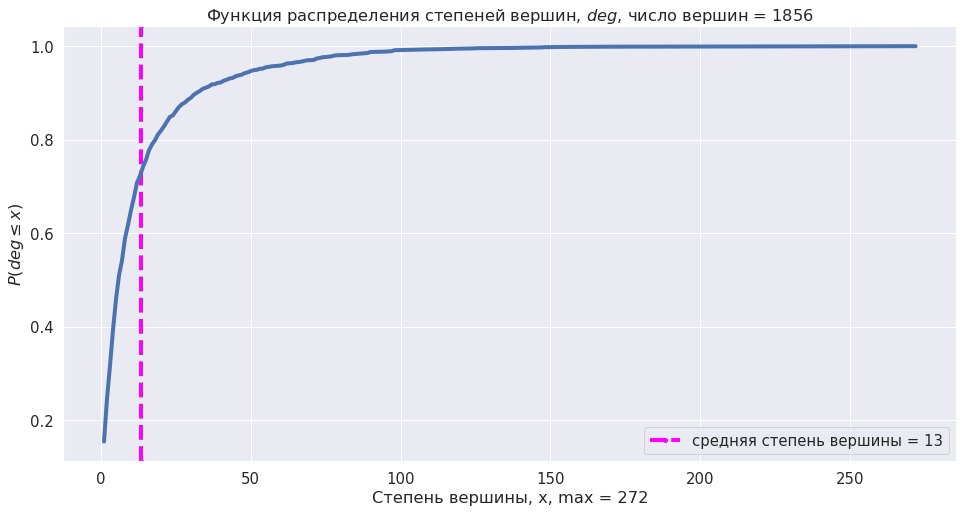

In [16]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

results = powerlaw.Fit(degree_sequence, discrete=True, xmin=1)
fit_deg, fit_pdf = results.pdf(original_data=degree_sequence)

deg = np.array(deg)
cnt = np.array(cnt)

sns.set(font_scale=1.35)
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
plt.title("Гистограмма степеней вершин")
ax.bar(deg, cnt, width=1, color='b')
ax.set_ylabel("Количество вершин, max = {0}".format(max(cnt)), color='b')
ax.tick_params('y', colors='b')
ax.set_xlabel("Степень вершины, max = {0}".format(max(deg)))
ax1 = ax.twinx()
ax1.plot(fit_deg[:-1], fit_pdf, color='g', linewidth=4)
ax1.set_ylabel(r'Плотность по степенному закону, $\alpha = $%0.2g'%(results.alpha), color='g')
ax1.tick_params('y', colors='g')
plt.xlim([0, 100])
plt.show()

sns.set(font_scale=1.35)
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

cnt = cnt / cnt.sum()
args = deg.argsort()

mean_deg = (cnt * deg).sum()

plt.axvline(x=mean_deg, color='magenta', linestyle='--',
            label=r'средняя степень вершины = %0.2g'%(mean_deg),
            linewidth=4, marker='o', markersize=4)

plt.plot(deg[args], cnt[args].cumsum(), linewidth=4)

plt.legend(loc=4)

plt.title("Функция распределения степеней вершин, $deg$, число вершин = %i"%(df.index.values.size))
plt.xlabel("Степень вершины, x, max = {0}".format(max(deg)))
plt.ylabel("$P(deg\leq x)$")
plt.show()

In [17]:
shortest_path_dicts = dict(nx.shortest_path_length(G))

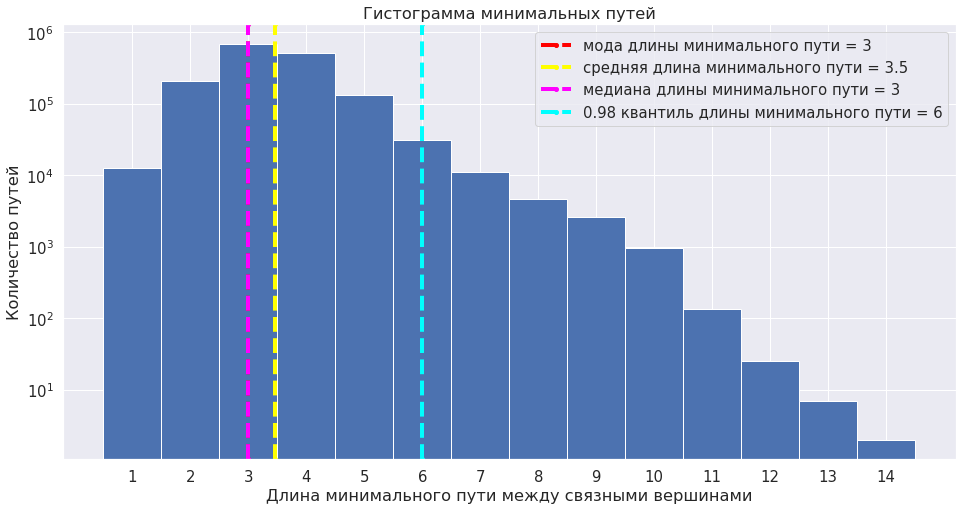

In [18]:
path_length_list = []

vertices =  df.index.values

for i in range(1, vertices.size + 1):
    for j in range(i + 1, vertices.size + 1):
        l = shortest_path_dicts[i].get(j, -1)
        if l > 0:
            path_length_list.append(l)

length_counter = Counter(path_length_list)
length, cnt = zip(*length_counter.items())

sns.set(font_scale=1.35)
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
plt.title("Гистограмма минимальных путей")
ax.bar(length, cnt, width=1, color='b')
ax.set_ylabel("Количество путей")
ax.set_xlabel("Длина минимального пути между связными вершинами")
ax.set_xticks([d for d in length])
ax.set_xticklabels(length)
ax.set_yscale('log')
plt.axvline(x=np.argmax(cnt) + 1, color='red', linestyle='--',
            label=r'мода длины минимального пути = %i'%(np.argmax(cnt) + 1), linewidth=4, marker='o', markersize=4)
cnt = np.array(cnt)
length = np.array(length)
cnt = cnt / cnt.sum()
mean = (cnt * length).sum()
plt.axvline(x=mean, color='yellow', linestyle='--',
            label=r'средняя длина минимального пути = %0.2g'%(mean),
            linewidth=4, marker='o', markersize=4)
median = np.argmax(cnt.cumsum() > 0.5) + 1
plt.axvline(x=median, color='magenta', linestyle='--',
            label=r'медиана длины минимального пути = %i'%(median),
            linewidth=4, marker='o', markersize=4)
quantile98 = np.argmax(cnt.cumsum() > 0.98) + 1
plt.axvline(x=quantile98, color='cyan', linestyle='--',
            label=r'0.98 квантиль длины минимального пути = %i'%(quantile98),
            linewidth=4, marker='o', markersize=4)
plt.legend(loc=1)
plt.show()

In [ ]:
omega = nx.omega(G, niter=100, nrand=10, seed=517)
print('Omega: ', omega)
sigma = nx.sigma(G, niter=100, nrand=10, seed=517)
print('Sigma: ', sigma)

In [19]:
cluster_coef_nodes = nx.clustering(G)

In [20]:
def get_node_val_lists(node_val_dict):
    node_list = []
    val_list = []

    for node, val in node_val_dict.items():
        node_list.append(node)
        val_list.append(val)
    
    node_list = np.array(node_list)
    val_list = np.array(val_list)

    args = np.argsort(node_list)
    node_list = node_list[args]
    val_list = val_list[args]
    return node_list, val_list

In [21]:
node_list, cluster_coef_list = get_node_val_lists(cluster_coef_nodes)

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


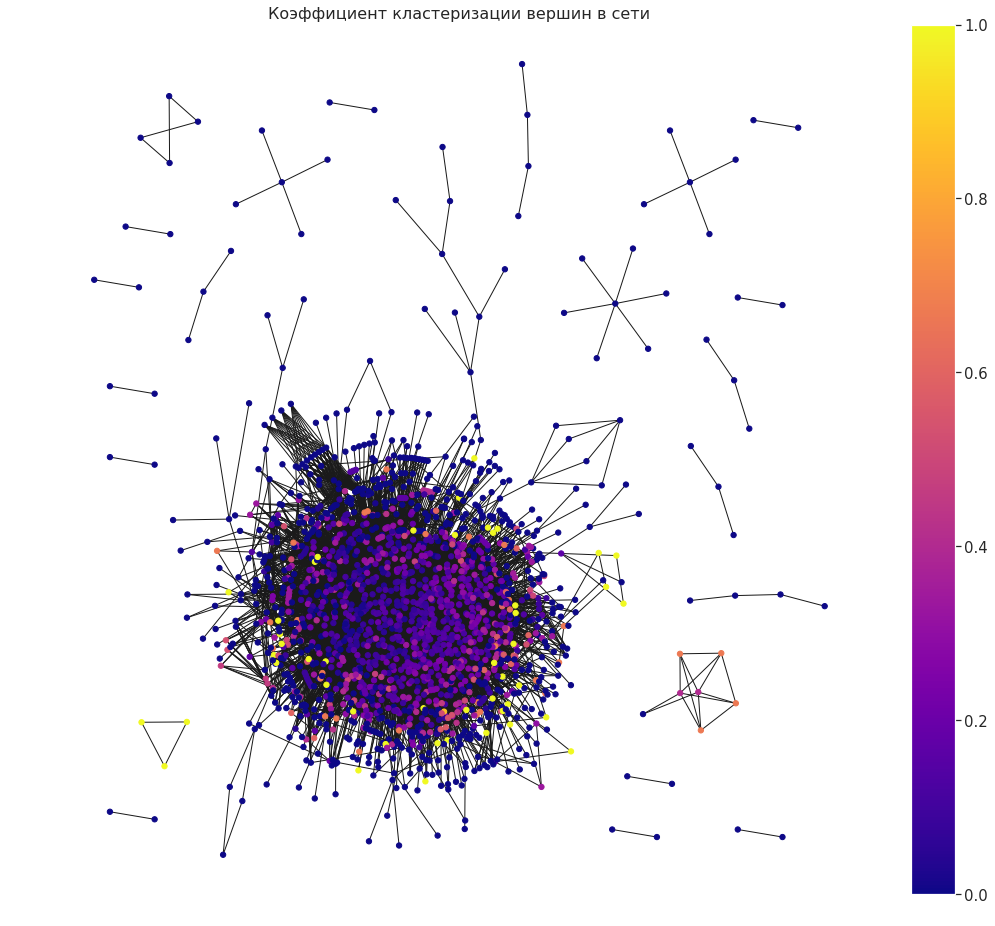

In [22]:
plotting(G, colors=cluster_coef_list, draw_color_bar=True, title='Коэффициент кластеризации вершин в сети',
         figsize=(18, 16))

In [23]:
def plot_hist(data, title, mean_title, median_title, x_label, y_label, nbins=80, figsize=(16, 8)):
    sns.set(font_scale=1.35)
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize[0], figsize[1])
    plt.title(title)
    ax.hist(data, bins=nbins, color='b')
    plt.axvline(x=data.mean(), color='yellow', linestyle='--',
                label=mean_title,
                linewidth=4, marker='o', markersize=4)
    plt.axvline(x=np.median(data), color='red', linestyle='--',
                label=median_title,
                linewidth=4, marker='o', markersize=4)
    ax.set_ylabel(y_label)
    plt.legend(loc=1)
    ax.set_xlabel(x_label)
    plt.show()

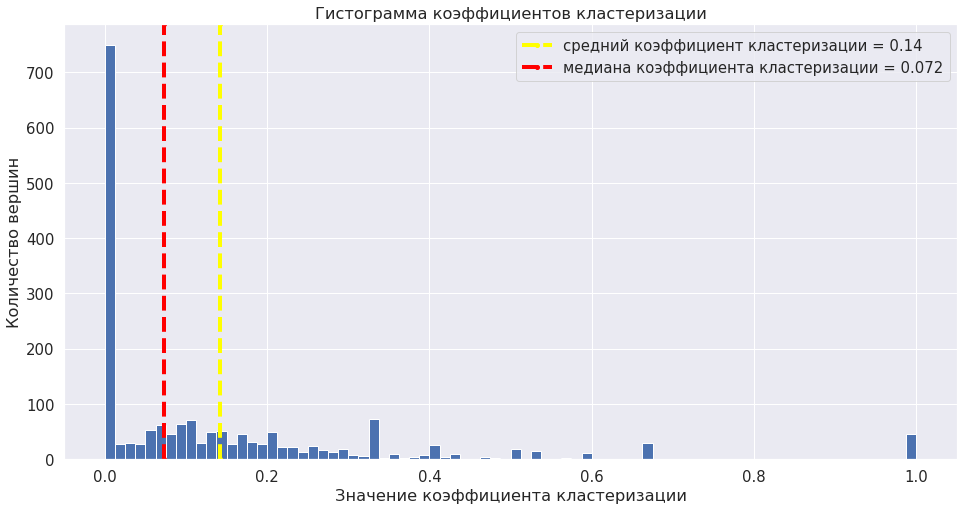

In [24]:
plot_hist(data=cluster_coef_list, title="Гистограмма коэффициентов кластеризации",
          mean_title=r'средний коэффициент кластеризации = %0.2g'%(cluster_coef_list.mean()),
          median_title=r'медиана коэффициента кластеризации = %0.2g'%(np.median(cluster_coef_list)),
          x_label="Значение коэффициента кластеризации",
          y_label="Количество вершин")

In [25]:
degree_centrality_dict = nx.degree_centrality(G)

In [26]:
node_list, degree_centrality_list = get_node_val_lists(degree_centrality_dict)

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


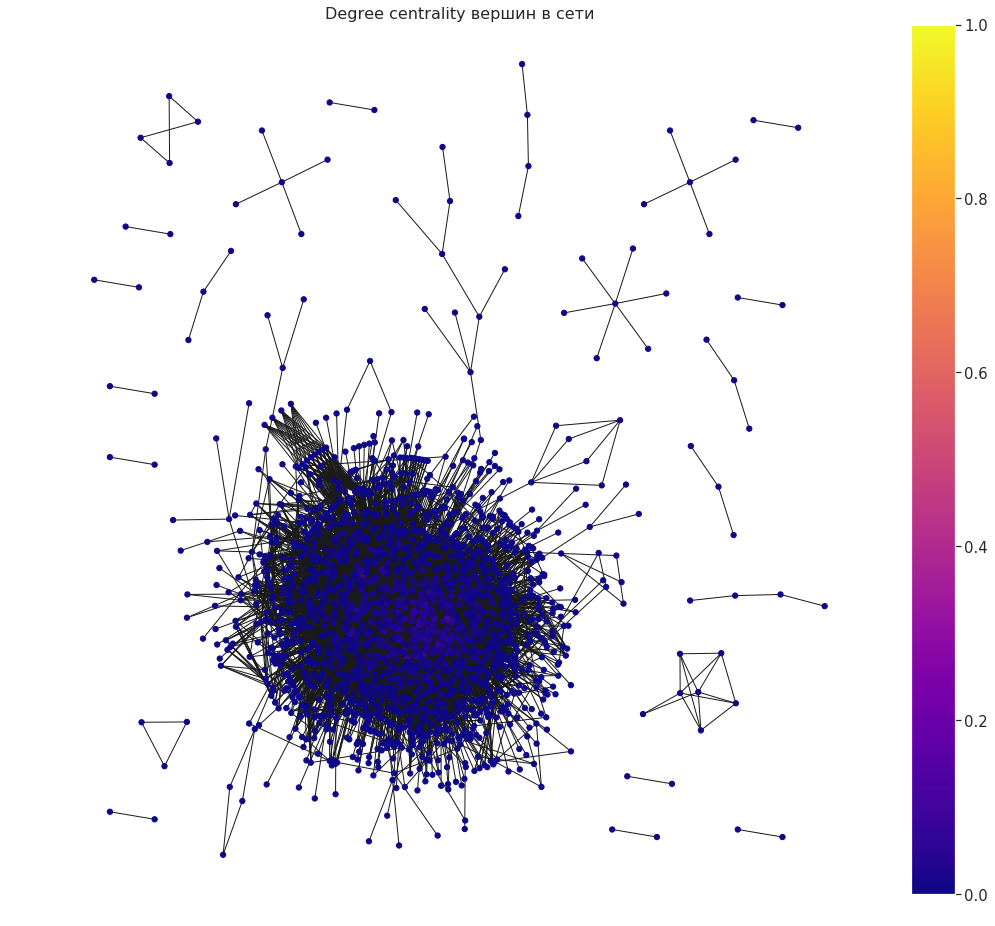

In [27]:
plotting(G, colors=degree_centrality_list, draw_color_bar=True, title='Degree centrality вершин в сети',
         figsize=(18, 16))

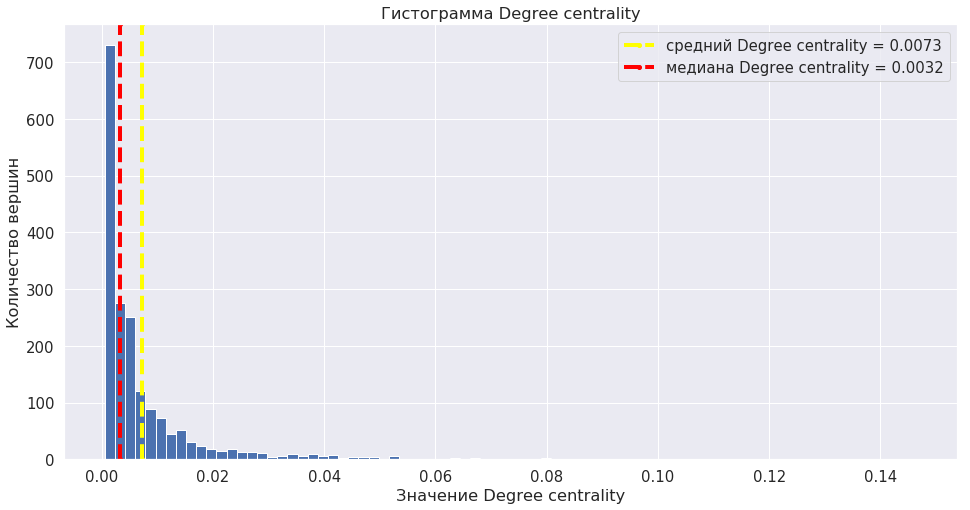

In [28]:
plot_hist(data=degree_centrality_list, title="Гистограмма Degree centrality",
          mean_title=r'средний Degree centrality = %0.2g'%(degree_centrality_list.mean()),
          median_title=r'медиана Degree centrality = %0.2g'%(np.median(degree_centrality_list)),
          x_label="Значение Degree centrality",
          y_label="Количество вершин")

In [29]:
eig_centrality_dict = nx.eigenvector_centrality_numpy(G)

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


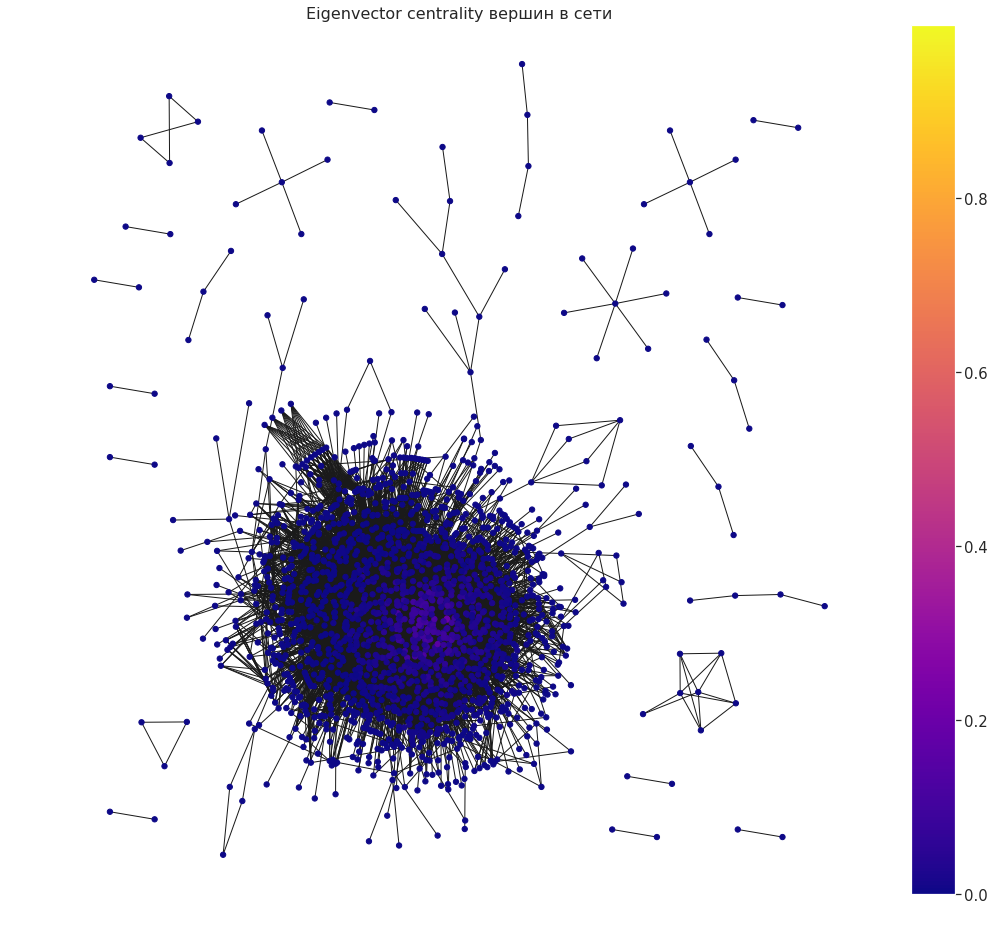

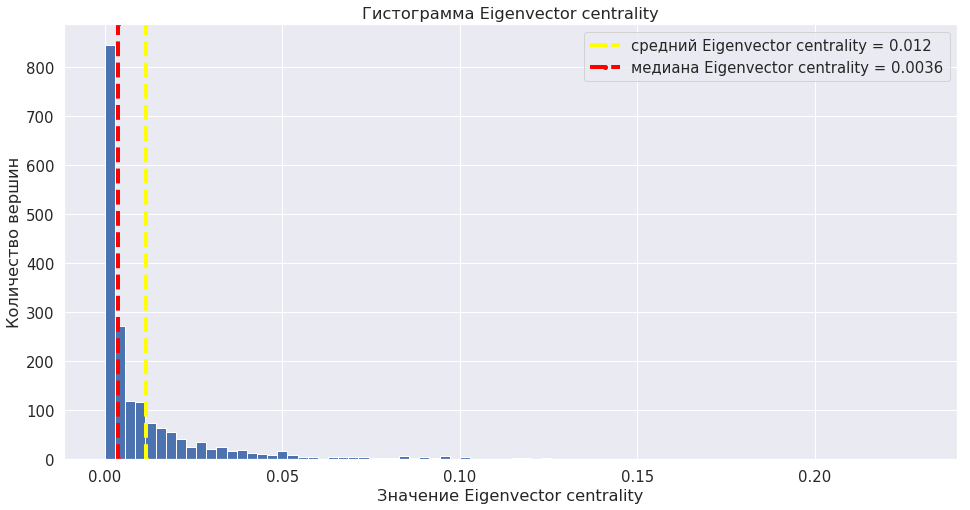

In [30]:
node_list, eig_centrality_list = get_node_val_lists(eig_centrality_dict)
plotting(G, colors=eig_centrality_list, draw_color_bar=True, title='Eigenvector centrality вершин в сети',
         figsize=(18, 16))
plot_hist(data=eig_centrality_list, title="Гистограмма Eigenvector centrality",
          mean_title=r'средний Eigenvector centrality = %0.2g'%(eig_centrality_list.mean()),
          median_title=r'медиана Eigenvector centrality = %0.2g'%(np.median(eig_centrality_list)),
          x_label="Значение Eigenvector centrality",
          y_label="Количество вершин")

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


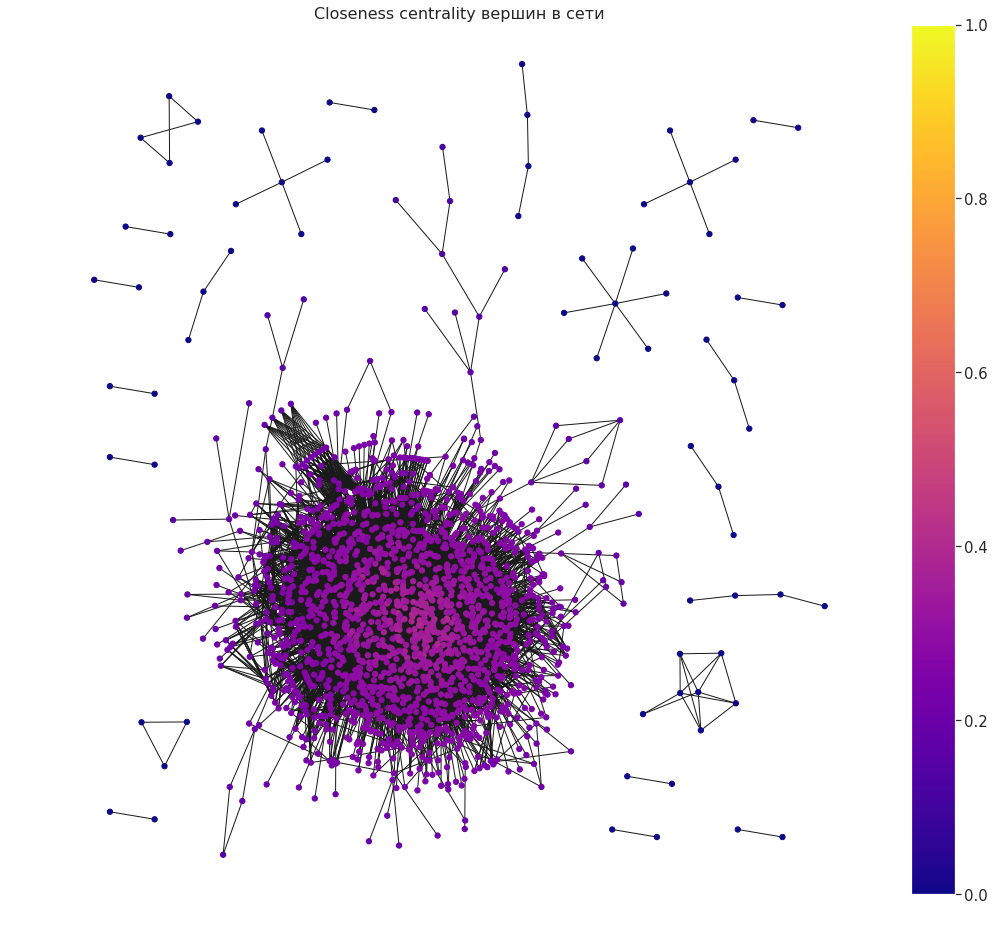

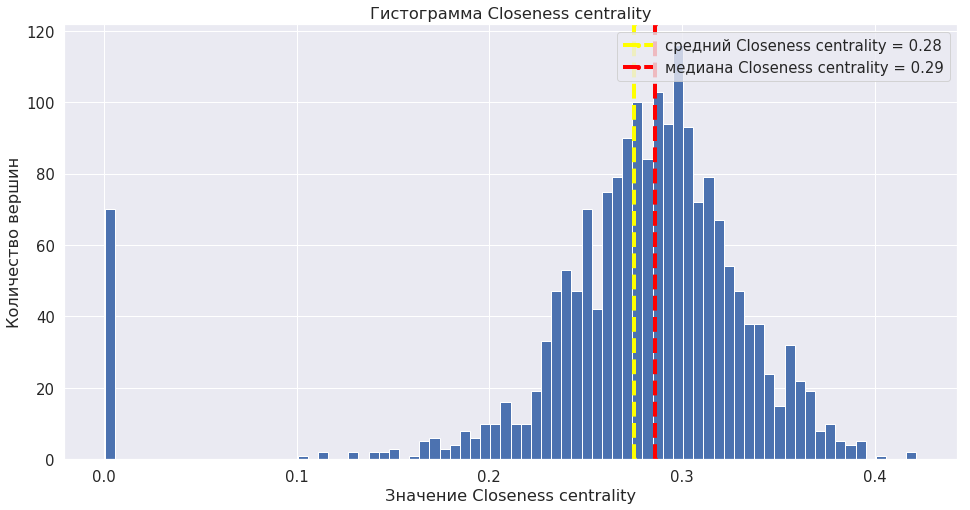

In [31]:
closeness_centrality_dict = nx.closeness_centrality(G)
node_list, closeness_centrality_list = get_node_val_lists(closeness_centrality_dict)
plotting(G, colors=closeness_centrality_list, draw_color_bar=True, title='Closeness centrality вершин в сети',
         figsize=(18, 16))
plot_hist(data=closeness_centrality_list, title="Гистограмма Closeness centrality",
          mean_title=r'средний Closeness centrality = %0.2g'%(closeness_centrality_list.mean()),
          median_title=r'медиана Closeness centrality = %0.2g'%(np.median(closeness_centrality_list)),
          x_label="Значение Closeness centrality",
          y_label="Количество вершин")

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


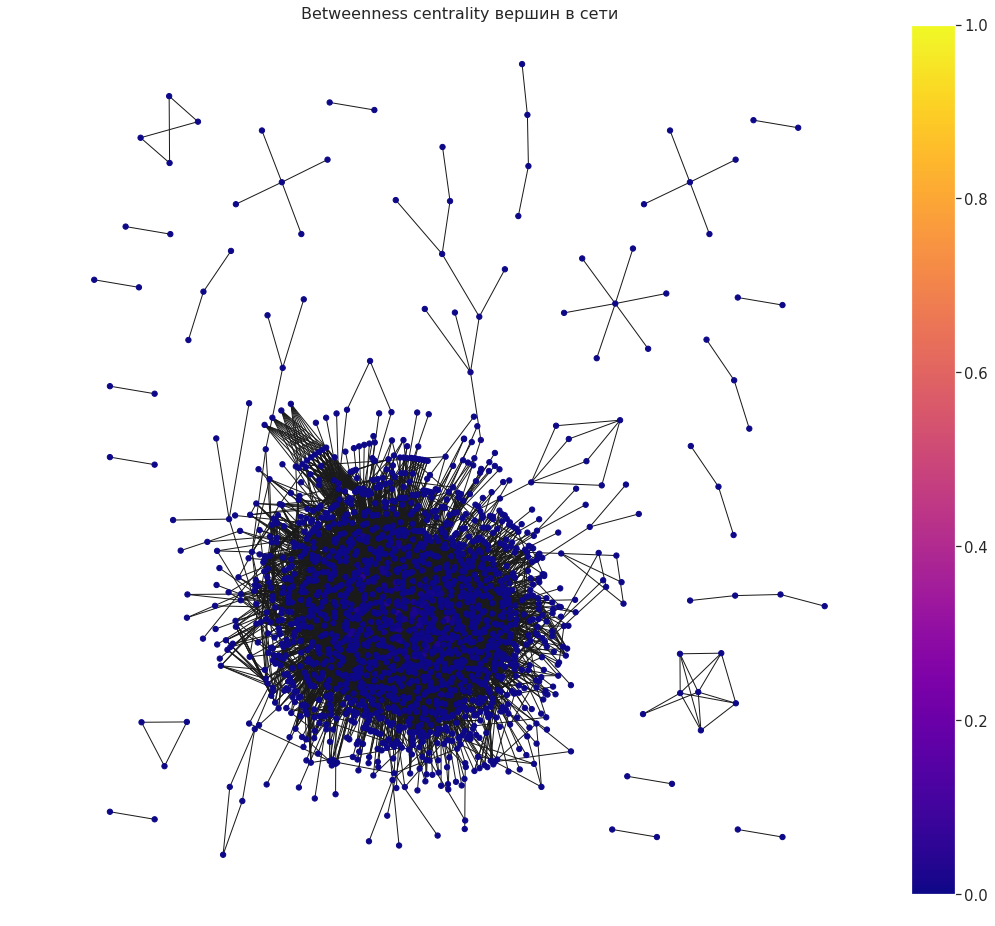

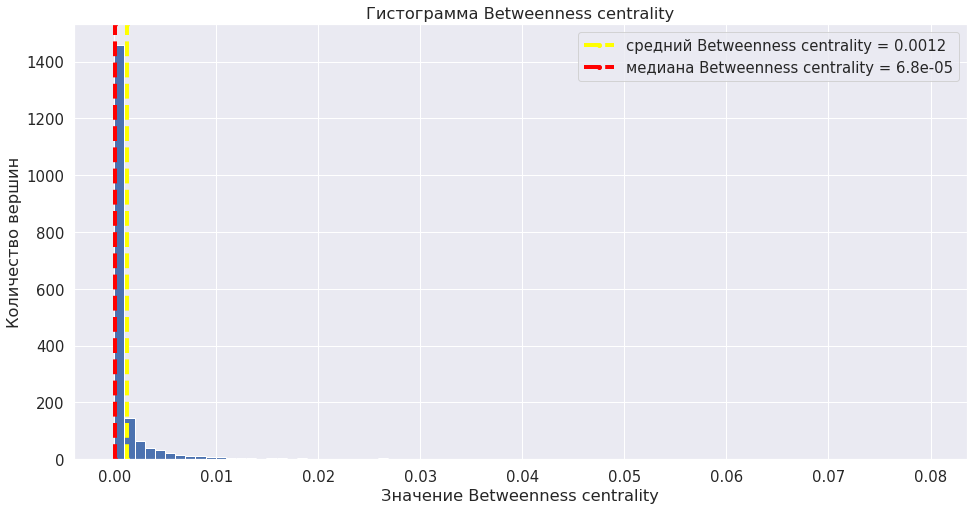

In [32]:
betweenness_centrality_dict = nx.betweenness_centrality(G)
node_list, betweenness_centrality_list = get_node_val_lists(betweenness_centrality_dict)
plotting(G, colors=betweenness_centrality_list, draw_color_bar=True, title='Betweenness centrality вершин в сети',
         figsize=(18, 16))
plot_hist(data=betweenness_centrality_list, title="Гистограмма Betweenness centrality",
          mean_title=r'средний Betweenness centrality = %0.2g'%(betweenness_centrality_list.mean()),
          median_title=r'медиана Betweenness centrality = %0.2g'%(np.median(betweenness_centrality_list)),
          x_label="Значение Betweenness centrality",
          y_label="Количество вершин")

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


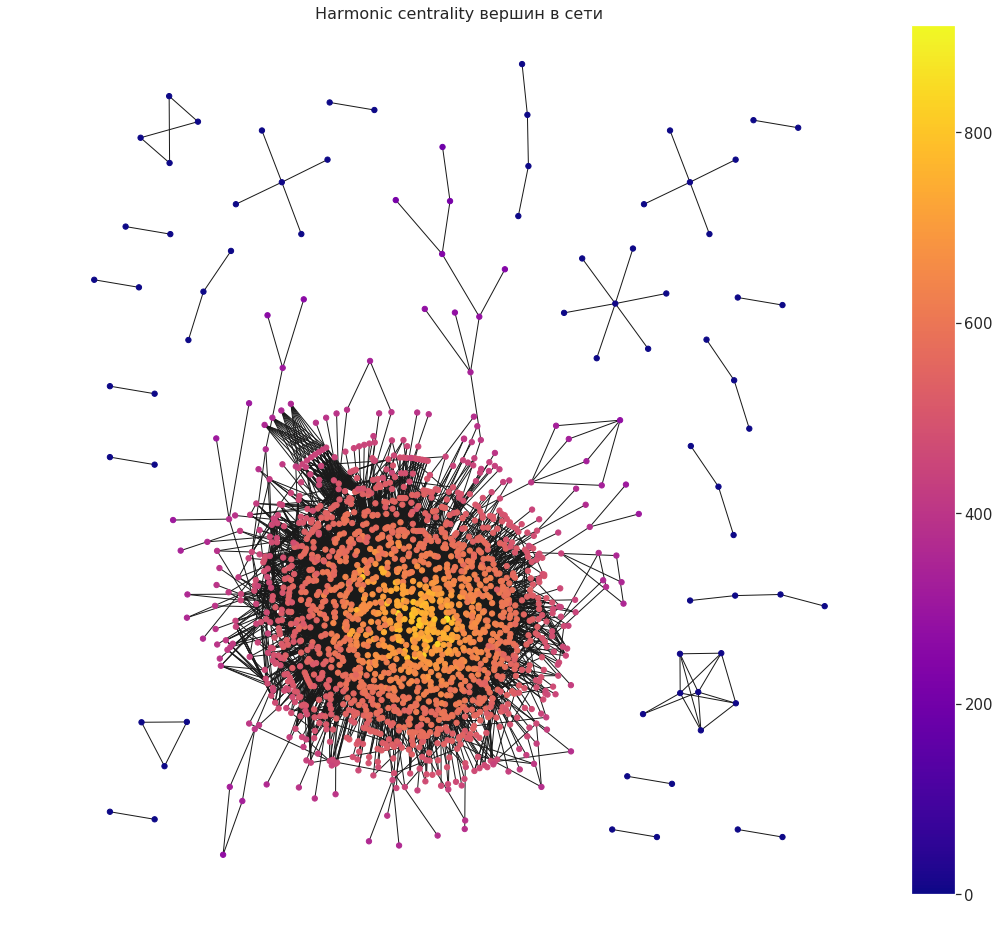

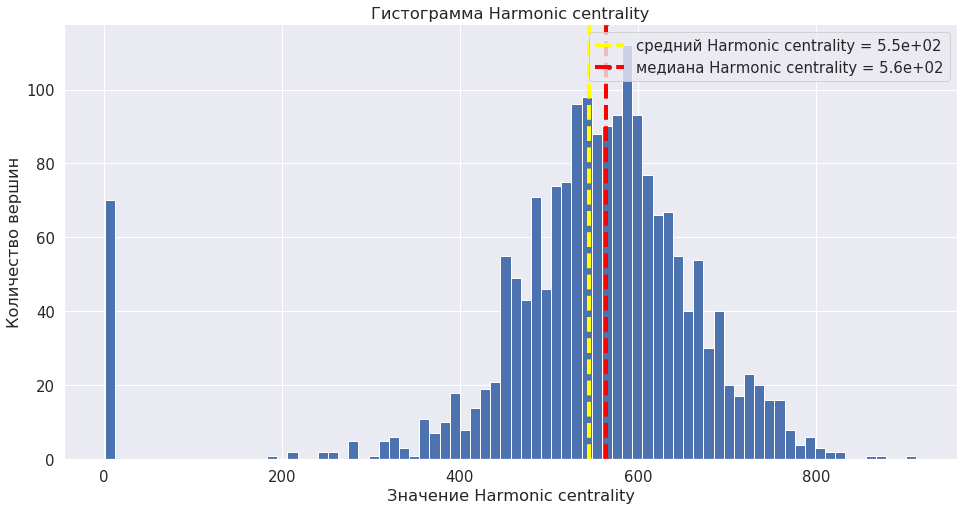

In [33]:
harmonic_centrality_dict = nx.harmonic_centrality(G)
node_list, harmonic_centrality_list = get_node_val_lists(harmonic_centrality_dict)
plotting(G, colors=harmonic_centrality_list, draw_color_bar=True, title='Harmonic centrality вершин в сети',
         figsize=(18, 16))
plot_hist(data=harmonic_centrality_list, title="Гистограмма Harmonic centrality",
          mean_title=r'средний Harmonic centrality = %0.2g'%(harmonic_centrality_list.mean()),
          median_title=r'медиана Harmonic centrality = %0.2g'%(np.median(harmonic_centrality_list)),
          x_label="Значение Harmonic centrality",
          y_label="Количество вершин")

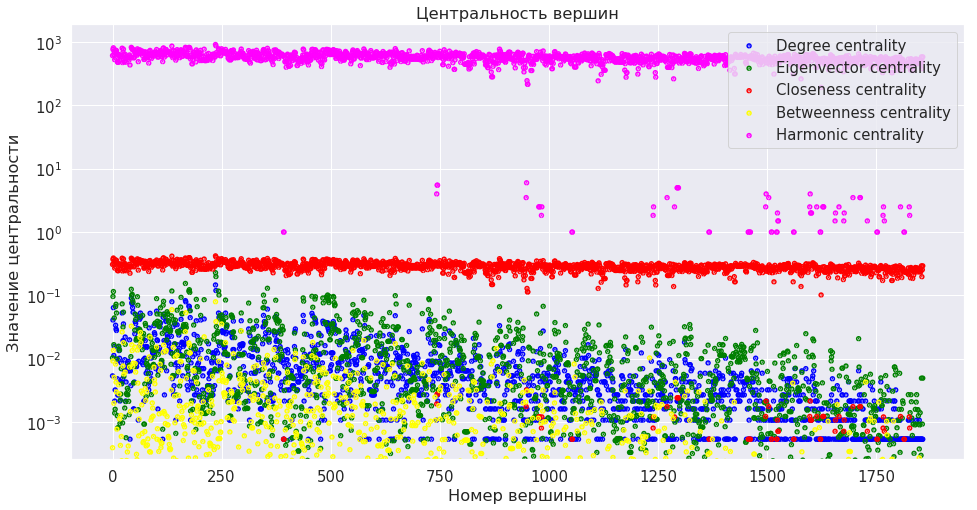

In [42]:
sns.set(font_scale=1.35)
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
plt.yscale('log')
plt.title('Центральность вершин')
plt.scatter(np.arange(degree_centrality_list.size), degree_centrality_list, color='blue', linestyle='--',
            label='Degree centrality',
            linewidth=4, marker='o', s=2)
plt.scatter(np.arange(eig_centrality_list.size), eig_centrality_list, color='green', linestyle='--',
            label='Eigenvector centrality',
            linewidth=4, marker='o', s=2)
plt.scatter(np.arange(closeness_centrality_list.size), closeness_centrality_list, color='red', linestyle='--',
            label='Closeness centrality',
            linewidth=4, marker='o', s=2)
plt.scatter(np.arange(betweenness_centrality_list.size), betweenness_centrality_list, color='yellow',
            linestyle='--',
            label='Betweenness centrality',
            linewidth=4, marker='o', s=2)
plt.scatter(np.arange(harmonic_centrality_list.size), harmonic_centrality_list, color='magenta', linestyle='--',
            label='Harmonic centrality',
            linewidth=4, marker='o', s=2)
ax.set_ylabel('Значение центральности')
plt.legend(loc=1)
ax.set_xlabel('Номер вершины')
plt.show()

In [44]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1858
Number of edges: 12534
Average degree:  13.4919
